In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sympy import *
from sympy.abc import x

In [26]:
f = Function('f')
a = symbols('a')
roots = solve(Eq(a*x + x**3 - x**5, 0), x)

In [27]:
roots

[0,
 -sqrt(1/2 - sqrt(4*a + 1)/2),
 sqrt(1/2 - sqrt(4*a + 1)/2),
 -sqrt(sqrt(4*a + 1)/2 + 1/2),
 sqrt(sqrt(4*a + 1)/2 + 1/2)]

In [34]:
deriv = Derivative(a*x + x**3 - x**5, x, evaluate=True)

for root in roots:
    print(simplify(deriv.subs(x, root)))

a
-4*a + sqrt(4*a + 1) - 1
-4*a + sqrt(4*a + 1) - 1
-4*a - sqrt(4*a + 1) - 1
-4*a - sqrt(4*a + 1) - 1


In [42]:
solve(Eq(simplify(deriv.subs(x, roots[4])), 0))

[-1/4]

In [43]:
sns.set(context='talk', font_scale=1.0, color_codes=True, palette='deep', style='ticks',
        rc={'mathtext.fontset': 'cm', 'xtick.direction': 'in','ytick.direction': 'in',
            'axes.linewidth': 1.5, 'figure.dpi':80, 'text.usetex':False})

In [92]:
from scipy.special import softmax

class AttractorNetwork:
    ''' 
    Store a spin system with interaction matrix J, spin state S, and temperature T

    ...
    
    Attributes
    --------------
    stored_states : np.array(N,P)
        attractor states
    S : np.array(N)
        spin array
    T : float
        system temperature
    anneal : boolean
        whether or not to simulate annealing
    anneal_args : float
        argument(s) for decreasing the temperature
    
    Sub-functions
    --------------
    energy()
        returns current value of total energy in the absence of an external field (eqn 3.59)
    decrease_temperature(a = schedule parameter)
        defines the annealing schedule
    update(k = spin index)
        determines whether or not spin k flips and updates the spin array accordingly
        decrease temperature with each step, if annealling is on
    '''
    
    def __init__(self, stored_states, initial_state, initial_temp = 0, anneal = False, anneal_args = 0.005):
        self.stored_states = stored_states.copy()
        self.current_state = initial_state.copy()
        self.temperature = initial_temp
        self.anneal = anneal
        self.anneal_args = anneal_args

        self.N = len(self.stored_states[:, 0])

        rng = np.random.default_rng()
        self.x = rng.standard_normal()*0.01
        self.a = -1
        self.signals = np.array([0, self.x*(self.x - np.sqrt(np.abs(self.a))), self.x*(self.x + np.sqrt(np.abs(self.a)))])
    
    def diff_eq(self, x, a):
        return a*x - x**3
    
    def update_x(self):
        # Note: time unit = 1/N*update
        self.x = self.x + self.diff_eq(self.x, self.a)/self.N
        
    def update_a(self, step=0.01, limit=1):
        while self.a < limit:
            self.a = self.a + step
        
    def update_couplings(self):
        self.signals = np.array([0, self.x*(self.x - np.sqrt(np.abs(self.a))), self.x*(self.x + np.sqrt(np.abs(self.a)))])

    def decrease_temperature(self):
        self.temperature = self.temperature/(1 + self.anneal_args*self.temperature)

    def update_spin(self, k):
        strength = len(k)
        beta = 1/self.temperature
        self.current_state[k] = (self.stored_states.dot(softmax(beta*(1/self.N)*self.stored_states.T.dot(self.current_state) 
                                                        + beta*strength*self.signals)))[k]
    
        if self.anneal:
            self.decrease_temperature()

        self.update_a()
        self.update_x()
        self.update_couplings()

* how to normalize magnetizations
* plot energy
* decorrelated version
* what governs the spurious attractors that appear at low temperatures?
-> how can we measure temperature in vitro/vivo? how can we decrease/increase it to make spurious attractors appear or disappear?

In [99]:
# Choose a system size
N = 1000

# Choose P random states of size N to store
P = 3

# Generate random states to store
rng = np.random.default_rng()
stored_states = rng.standard_normal(size=(N, P))

# Choose a stored state as the initial state
initial_state = stored_states[:, 0]

# Choose a random state as the initial state
# initial_state = rng.standard_normal(size=N)

initial_temperature = 0.0001

attractor_network = AttractorNetwork(stored_states=stored_states, initial_state=initial_state, initial_temp=initial_temperature)#, anneal=True)

In [100]:
total_time = 10*N # how many time steps to take

time = range(total_time)
magnetizations = np.empty((P, total_time))

a_array = []
x_array = []

for t in time:
    magnetizations[:, t] = (1/N)*attractor_network.stored_states.T.dot(attractor_network.current_state)
    a_array += [attractor_network.a]
    x_array += [attractor_network.x]

    random_spin = rng.integers(low=0, high=N, size=1) # choose random spin from 0 to N to update
    attractor_network.update_spin(random_spin)

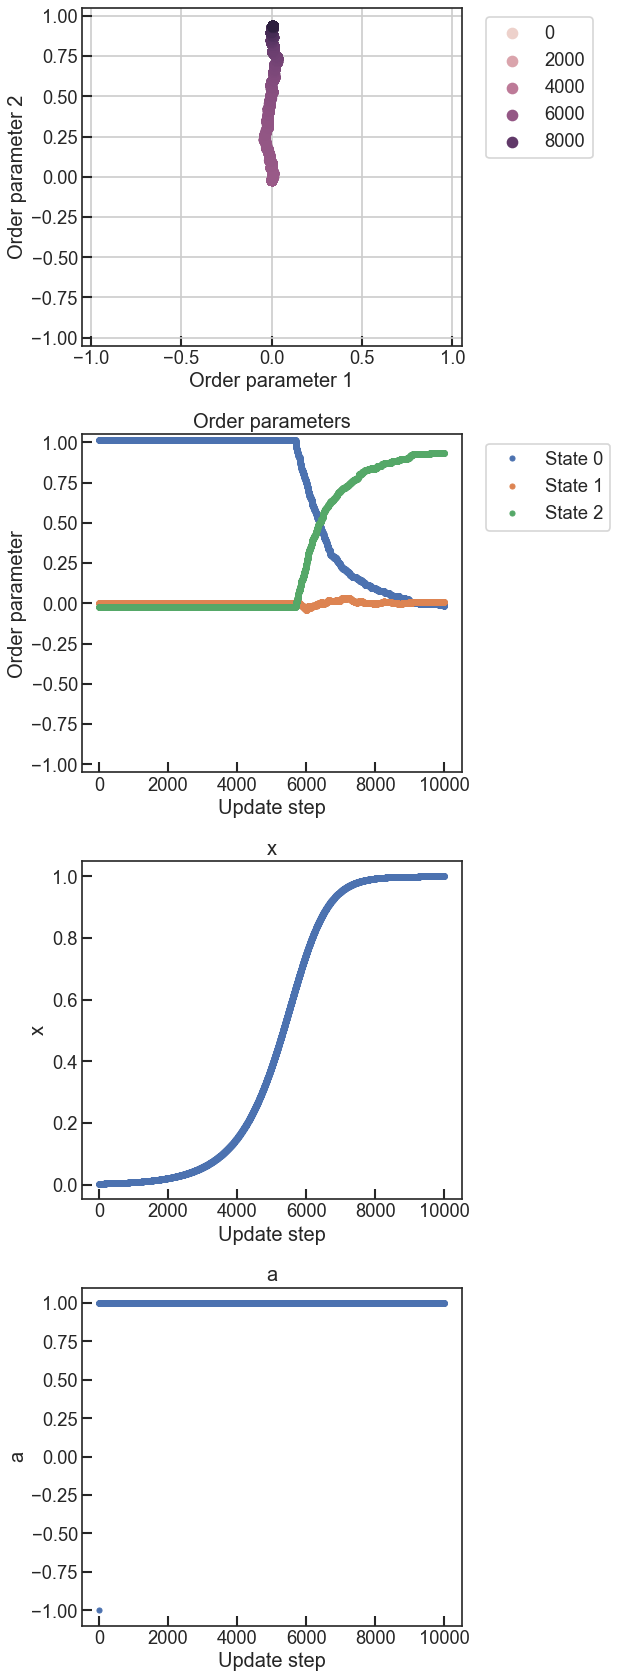

In [101]:
xaxis = 1 # which order parameter to plot on x-axis
yaxis = 2 # which order parameter to plot on y-axis

nplots = 4
xlength = 8

plt.figure(figsize=(xlength, xlength*nplots*(2/3)))

plt.subplot(nplots, 1, 1)
plt.xlabel('Order parameter {}'.format(xaxis))
plt.ylabel('Order parameter {}'.format(yaxis))
sns.scatterplot(x=magnetizations[xaxis], y=magnetizations[yaxis], hue=time, edgecolor=None)
plt.xlim([-1.05,1.05])
plt.ylim([-1.05,1.05])
plt.grid()
plt.legend(bbox_to_anchor=(1.04, 1.), loc='upper left')

plt.subplot(nplots, 1, 2)
plt.title('Order parameters')
for i in range(P):
    plt.plot(time, magnetizations[i], '.', label="State {}".format(i))
plt.ylim([-1.05,1.05])
plt.legend(bbox_to_anchor=(1.04, 1.), loc='upper left')
plt.ylabel('Order parameter')
plt.xlabel('Update step')

plt.subplot(nplots, 1, 3)
plt.title('x')
plt.plot(time, x_array, '.')
plt.ylabel('x')
plt.xlabel('Update step')

plt.subplot(nplots, 1, 4)
plt.title('a')
plt.plot(time, a_array, '.')
plt.ylabel('a')
plt.xlabel('Update step')

plt.tight_layout()
plt.show()

In [93]:
# Simulate dynamics for a given set of parameters `n_trials` times, and return the final order parameters

def simulate_dynamics(n_trials, total_time, initial_temperature):
    magnetizations = np.empty((P, n_trials))

    for n in range(n_trials):
        stored_states = rng.standard_normal(size=(N, P))

        # initial_state = rng.standard_normal(size=N)
        initial_state = stored_states[:, 0]
        
        attractor_network = AttractorNetwork(stored_states=stored_states, initial_state=initial_state, initial_temp=initial_temperature)

        t = 0
        while t < total_time:
            random_spin = rng.integers(low=0, high=N, size=200) # choose random spin(s) from 0 to N to update
            attractor_network.update_spin(random_spin)

            t += 1

        magnetizations[:, n] = (1/N)*attractor_network.stored_states.T.dot(attractor_network.current_state)
    
    return magnetizations

In [94]:
initial_temperature = 1e-10
order_params = simulate_dynamics(100, 5*N, initial_temperature=initial_temperature)

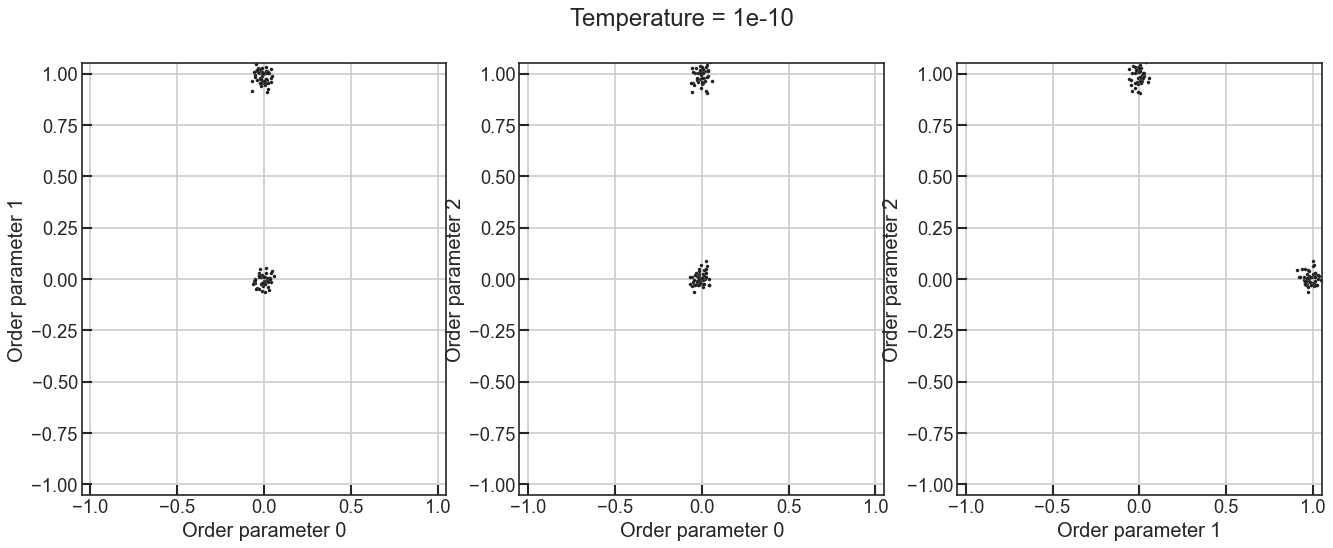

In [95]:
plt.figure(figsize=(20, 7))
nplots = 3

plt.suptitle('Temperature = {}'.format(initial_temperature))

plt.subplot(1, nplots, 1)
plt.xlabel('Order parameter 0')
plt.ylabel('Order parameter 1')
sns.scatterplot(x=order_params[0], y=order_params[1], color='k', linewidth=0.1, s=10)
plt.xlim([-1.05,1.05])
plt.ylim([-1.05,1.05])
plt.grid()

plt.subplot(1, nplots, 2)
plt.xlabel('Order parameter 0')
plt.ylabel('Order parameter 2')
sns.scatterplot(x=order_params[0], y=order_params[2], color='k', linewidth=0.1, s=10)
plt.xlim([-1.05,1.05])
plt.ylim([-1.05,1.05])
plt.grid()

plt.subplot(1, nplots, 3)
plt.xlabel('Order parameter 1')
plt.ylabel('Order parameter 2')
sns.scatterplot(x=order_params[1], y=order_params[2], color='k', linewidth=0.1, s=10)
plt.xlim([-1.05,1.05])
plt.ylim([-1.05,1.05])
plt.grid()

plt.show()

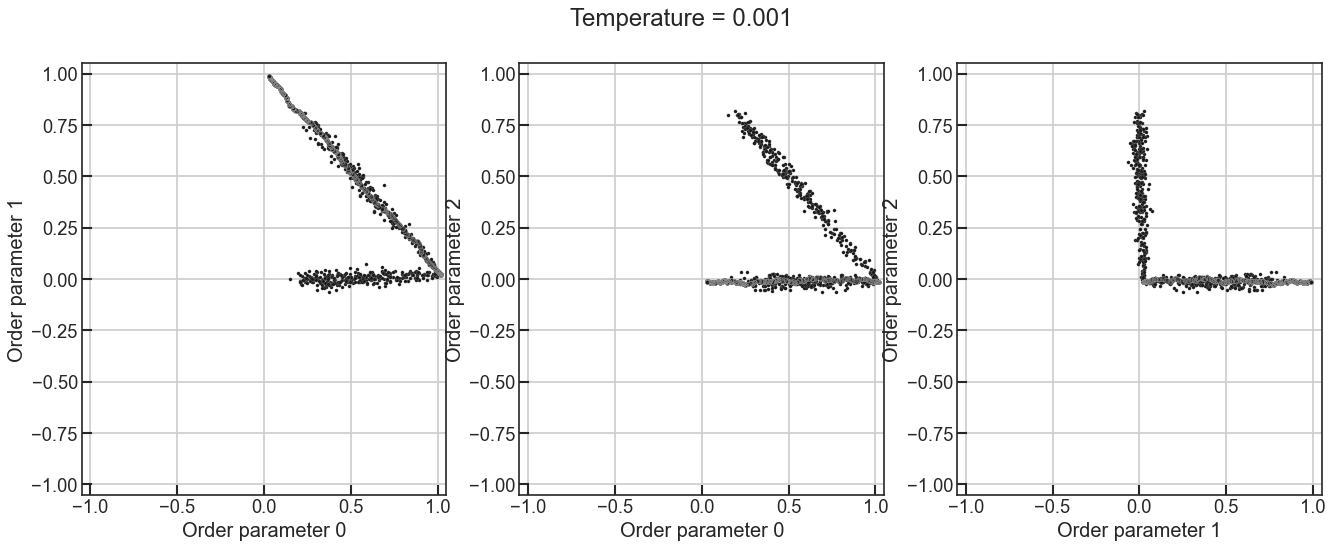

In [302]:
# order_params2 = simulate_dynamics(1000, 5*N, initial_state, stored_states, initial_temperature=0.001)

plt.figure(figsize=(20, 7))
nplots = 3

plt.suptitle('Temperature = {}'.format(0.001))

plt.subplot(1, nplots, 1)
plt.xlabel('Order parameter 0')
plt.ylabel('Order parameter 1')
sns.scatterplot(x=order_params2[0], y=order_params2[1], color='k', linewidth=0.1, s=10)
plt.xlim([-1.05,1.05])
plt.ylim([-1.05,1.05])
plt.grid()

plt.subplot(1, nplots, 2)
plt.xlabel('Order parameter 0')
plt.ylabel('Order parameter 2')
sns.scatterplot(x=order_params2[0], y=order_params2[2], color='k', linewidth=0.1, s=10)
plt.xlim([-1.05,1.05])
plt.ylim([-1.05,1.05])
plt.grid()

plt.subplot(1, nplots, 3)
plt.xlabel('Order parameter 1')
plt.ylabel('Order parameter 2')
sns.scatterplot(x=order_params2[1], y=order_params2[2], color='k', linewidth=0.1, s=10)
plt.xlim([-1.05,1.05])
plt.ylim([-1.05,1.05])
plt.grid()

plt.show()

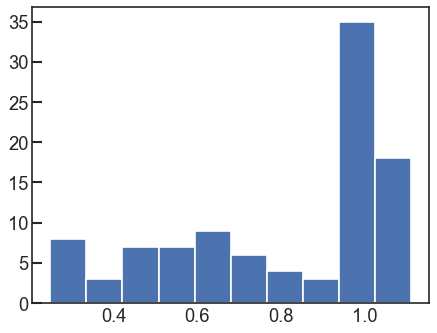

In [87]:
plt.hist(order_params[0])
plt.show()

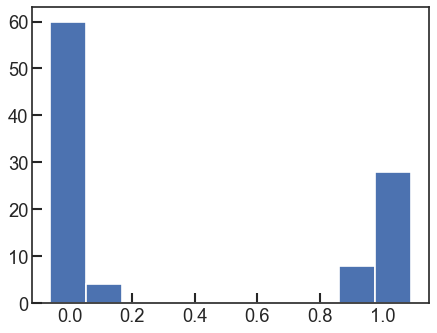

In [91]:
plt.hist(order_params[0])
plt.show()

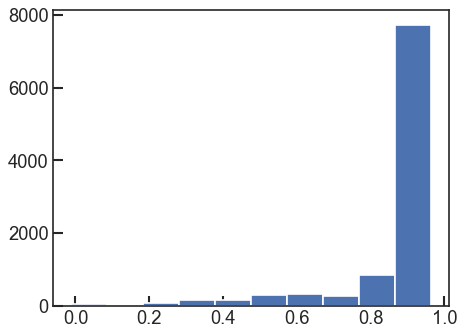

In [25]:
plt.hist(order_params[0])
plt.show()